<h1 style="text-align: center;">
    🏷️ Multi-Label Multi-Class classification
</h1>

This notebook demonstrates how to generate **multi-label** streams with `streamgen`.

The scikit-learn docs explain the concept well:

> Multilabel classification (closely related to multioutput classification) is a classification task labeling each sample with `m` labels from `n_classes` possible classes, where `m´ can be 0 to ´n_classes´ inclusive. This can be thought of as predicting properties of a sample that are not mutually exclusive. Formally, a binary output is assigned to each class, for every sample. Positive classes are indicated with 1 and negative classes with 0 or -1. It is thus comparable to running ´n_classes´ binary classification tasks. This approach treats each label independently whereas multilabel classifiers may treat the multiple classes simultaneously, accounting for correlated behavior among them.

we will start construct a simple multi-label use-case from our time series example.

There is no obvious way to model such a use-case with a tree structure, so we will present several options.

> 🤔 the `streamgen` API and the concept of a sampling tree are more suitable for the standard single-label multi-class task. Using the framework for the multi-label use-case will demonstrate the rougher edges of the framework, so we recommend this guide only for experienced users.

---

In [1]:
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns

from streamgen.nodes import ClassLabelNode
from streamgen.samplers.tree import SamplingTree
from streamgen.transforms import noop, operate_on_index

SEED = 42
rng = np.random.default_rng(SEED)

sns.set_theme()

output_path = Path("./")
output_path.mkdir(parents=True, exist_ok=True)

## 🌳 Using `streamgen` primitives

previously, the label information was added in the leaf nodes, so there was no need to:

+ adapt the implicit, default `None` input to the first transformation
+ carry the label information through the sampling process

In multi-label data generation, annotations can be added in every node in the tree, so we need to add the list of labels to the input and output of every node:

```python
def multi_label_transform(input: tuple[np.ndarray, list[str]], **kwargs) -> tuple[np.ndarray, list[str]]:
    x, y = input

    # do something with x and/or y

    return (x, y)
```

Since most functions only transform either transform the sample `x` or the annotation `y`, `streamgen` provides a decorator `streamgen.transforms.operate_on_index` to automatically handle the correct passing of the part that are not modified. The following function passes the labels automatically to the output:

```python
@operate_on_index(0)
def multi_label_transform(x: np.ndarray, **kwargs) -> np.ndarray:

    # do something with x

    return x # the decorator will return (x, y)
```

Using this decorator, we can re-use the time-series transformations from the first notebook:

In [2]:
# ➡️ transforms and generators


@operate_on_index(0)
def background(signal_, signal_length: int, offset: float, strength: float) -> np.ndarray:  # noqa: D103, ANN001, ARG001
    return rng.normal(offset, strength, signal_length)


@operate_on_index(0)
def ramp(signal: np.ndarray, height: float, length: int) -> np.ndarray:  # noqa: D103
    ramp_signal = np.zeros(len(signal))
    ramp_start = rng.choice(range(len(signal) - length))
    ramp_signal[ramp_start : ramp_start + length] = np.linspace(0.0, height, length)
    return signal + ramp_signal


@operate_on_index(0)
def step(signal: np.ndarray, length: int, kernel_size: int) -> np.ndarray:  # noqa: D103
    step_signal = np.zeros(len(signal))
    step_start = rng.choice(range(len(signal) - length))
    step_signal[step_start : step_start + length] = 1.0
    kernel = np.ones(kernel_size) / kernel_size
    step_signal = np.convolve(step_signal, kernel, mode="same")
    return signal + step_signal

Now we will construct a tree with these transformations. The resulting samples will either contain no pattern (`[]`), a single pattern (`["ramp"]` or `["step"]`), or both at the same time (`["ramp", "step"]`).

An alternative to the list representation of the labels is the *powerset approach*, where you convert the multi-label task into a single-label one by representing each combination of labels as a seperate class (´"no-class"´, ´"ramp"´, ´"step"´ and ´"ramp-step"´). This approach does not scale well to problems with a high cardinality and a big set of possible values. We will focus on the list representation of the labels to showcase the details of the label handling in streamgen.

The default behavior of the shorthand string notation in the definition of a `streamgen.samplers.tree.SamplingTree` is to use the `streamgen.nodes.ClassLabelNode`, which by default just sets the label. For our task, we want those nodes to add/append the labels to the list of labels, so we need to tell streamgen to use these custom nodes when building the tree using the `string_node` argument.

There are two ways to construct the class distributions:

1. focus on the number of labels (cardinality) first and then sample which patterns to include.
2. model the probabilities of the presence of each label

We will first focus on the first modelling approach and later focus on the second one.

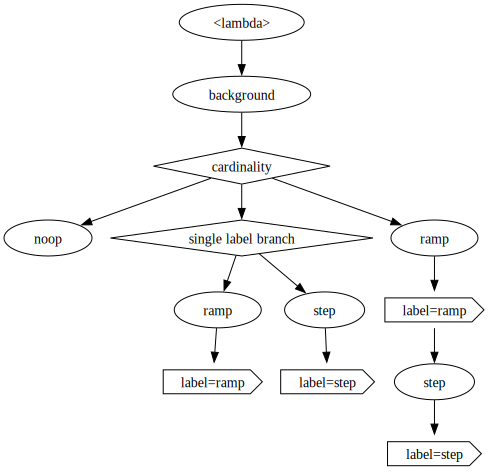

In [3]:
MultiLabelNode = partial(ClassLabelNode, label_func=lambda input, label: (input[0], input[1] + [label]))  # noqa: A002

transform_config = {
    "background.signal_length": 512,
    "background.offset": [0.0, 0.2, 0.5],
    "background.strength": [0.1, 0.2, 0.4],
    "ramp.height": 1.0,
    "ramp.length": 128,
    "step.length": 64,
    "step.kernel_size": 1,
}

df = pd.DataFrame(
    {
        "cardinality.probs": [
            [0.5, 0.3, 0.2],
            [0.6, 0.2, 0.2],
            [0.7, 0.2, 0.1],
        ],
        "single label branch.probs": [
            [0.8, 0.2],
            [0.6, 0.4],
            [0.4, 0.6],
        ],
    }
    | transform_config,
)

# 🎲🌳 tree of transformations
tree = SamplingTree(
    [
        lambda _: (None, []),
        background,
        {
            "name": "cardinality",
            "no label branch": noop,
            "single label branch": {
                "name": "single label branch",
                "ramp": [ramp, "ramp"],
                "step": [step, "step"],
            },
            "multi label branch": [
                ramp,
                "ramp",
                step,
                "step",
            ],
        },
    ],
    df,
    string_node=MultiLabelNode,
)

tree.to_svg(output_path / "multi_label_tree_1")

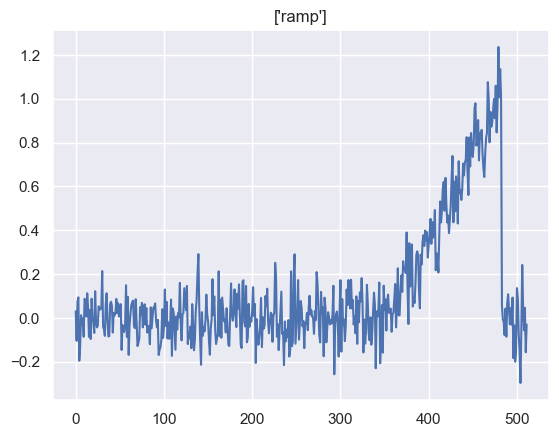

In [4]:
x, y = tree.sample()

sns.lineplot(x).set_title(str(y));

Now we will construct a second tree, where we focus on modelling the probabilities of the individual patterns being present (instead of the cardinality). An elegant way to generate such scenarios is through the use of stochastic transformations, where the decision if a transformation is applied (and a corresponding label is added) is also sampled from a distribution. With streamgen, we can use branches to perform this sampling:

```python
{
    "name": "maybe apply step transformation",
    "no step": noop,
    "step": [step, "step"],
}
```

Generally, we want to add the same transformations to both branches, but unfortunately, in a tree, branches cannot be **merged** (which would create a more general, directed acyclic graph).

> 🔮 other samplers like directed graphs of transformations might be added to `streamgen` in the future.

For convenience, `streamgen` automatically copies and appends nodes that appear after the definition of branches to every branch.

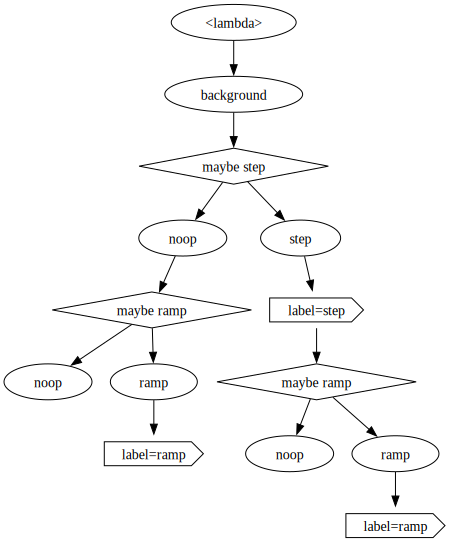

In [5]:
df = pd.DataFrame(
    {
        "maybe step.probs": [
            [0.8, 0.2],
            [0.6, 0.4],
            [0.4, 0.6],
        ],
        "maybe ramp.probs": [
            [0.1, 0.9],
            [0.1, 0.9],
            [0.4, 0.6],
        ],
    }
    | transform_config,
)

# 🎲🌳 tree of transformations
tree = SamplingTree(
    [
        lambda _: (None, []),
        background,
        {
            "name": "maybe step",
            "no step": noop,
            "step": [step, "step"],
        },
        {
            "name": "maybe ramp",
            "no ramp": noop,
            "ramp": [ramp, "ramp"],
        },
    ],
    df,
    string_node=MultiLabelNode,
)

tree.to_svg(output_path / "multi_label_tree_2")

In [6]:
tree.collect(100);

Output()

## 🎲 Writing more expressive functions

Another viable option is the inclusion of the stochastic application of the transform into the function definitions. This can drastically simplify the tree topology. In our simply example, we do not need any branches at all, falling back to a sequential composition of transformations (which can still be expressed by a `SamplingTree`).

Since the transforms themselves take care of adding the labels, we neither need the function decorators nor the special labelling nodes from earlier:

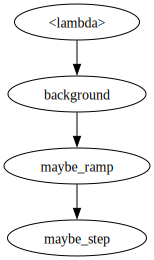

In [7]:
def maybe_ramp(input: tuple[np.ndarray, list[str]], height: float, length: int, p_apply: float = 0.5) -> np.ndarray:  # noqa: D103, A002
    signal, labels = input

    if rng.uniform() < p_apply:
        ramp_signal = np.zeros(len(signal))
        ramp_start = rng.choice(range(len(signal) - length))
        ramp_signal[ramp_start : ramp_start + length] = np.linspace(0.0, height, length)
        signal += ramp_signal
        labels.append("ramp")

    return signal, labels


def maybe_step(input: tuple[np.ndarray, list[str]], length: int, kernel_size: int, p_apply: float = 0.5) -> np.ndarray:  # noqa: D103, A002
    signal, labels = input

    if rng.uniform() < p_apply:
        step_signal = np.zeros(len(signal))
        step_start = rng.choice(range(len(signal) - length))
        step_signal[step_start : step_start + length] = 1.0
        kernel = np.ones(kernel_size) / kernel_size
        signal += np.convolve(step_signal, kernel, mode="same")
        labels.append("step")

    return signal, labels


df = pd.DataFrame(
    {
        "maybe_ramp.height": 1.0,
        "maybe_ramp.length": 64,
        "maybe_ramp.p_apply": 0.8,
        "maybe_step.length": 32,
        "maybe_step.kernel_size": 1,
        "maybe_step.p_apply": 0.9,
    }
    | transform_config,
)

# 🎲🌳 tree of transformations
tree = SamplingTree(
    [
        lambda _: (None, []),
        background,
        maybe_ramp,
        maybe_step,
    ],
    df,
)

tree.to_svg(output_path / "multi_label_tree_3")

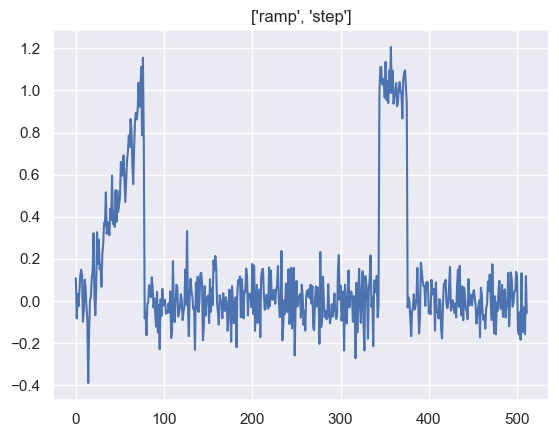

In [8]:
x, y = tree.sample()

sns.lineplot(x).set_title(str(y));